In [2]:
import pandas as pd
import matplotlib.pyplot as plt

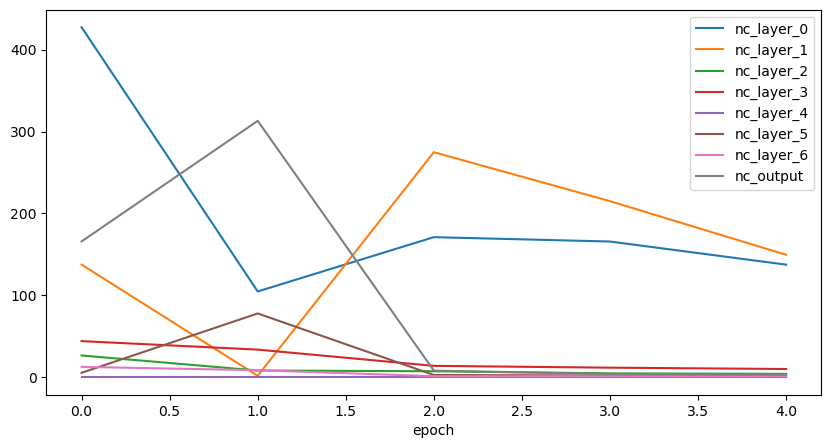

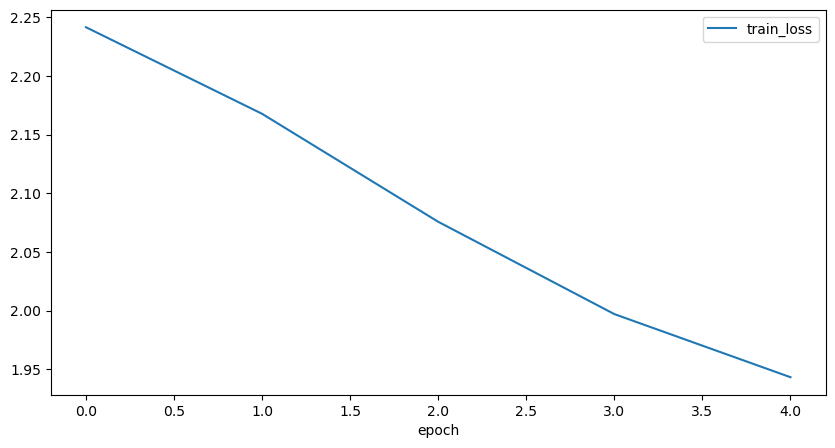

In [3]:
metrics = pd.read_csv("lightning_logs/version_3/metrics.csv")
metrics.drop(columns="step", inplace=True)
metrics.plot(x="epoch", y=metrics.columns[1:-2], figsize=(10, 5))
metrics.plot(x="epoch", y="train_loss", figsize=(10, 5))
plt.show()

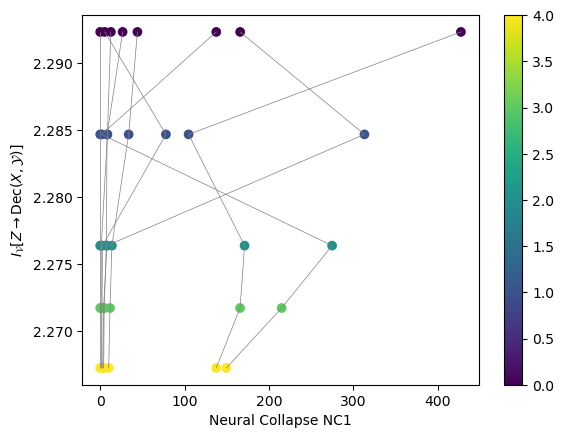

In [5]:
for nc in metrics.columns[1:-2]:
    plt.scatter(metrics[nc], metrics["v_info"], cmap="viridis", c=metrics["epoch"])
    plt.plot(metrics[nc], metrics["v_info"], color="gray", linewidth=0.5)
plt.xlabel("Neural Collapse NC1")
plt.ylabel(r"$I_{\mathcal{V}}[Z \to \operatorname{Dec}(X,\mathcal{Y})]$")
plt.colorbar()
plt.show()